# Finetune MAE Trajectories for Polymer Tasks

This notebook summarizes the finetuning behaviour of the dynamic pretrain suite.
For each PI property, we track the MAE reported after finetuning on models
trained with progressively larger pretrain task sequences. The goal is to highlight
how performance evolves as the target task is introduced into the pretrain stages.

In [50]:
import json
from pathlib import Path
from typing import Iterable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D


In [51]:
ARTIFACT_ROOT = Path("../artifacts/polymers_pretrain_finetune_runs")
RUN_PATTERN = "run*"
FINETUNE_TASKS = [
    "density",
    "Rg",
    "r2",
    "self-diffusion",
    "Cp",
    "Cv",
    "linear_expansion",
    "refractive_index",
    "tg",
]

if not ARTIFACT_ROOT.exists():
    raise FileNotFoundError(f"Expected artifact directory at {ARTIFACT_ROOT}")


In [52]:
def load_finetune_records(artifact_root: Path) -> pd.DataFrame:
    records: list[dict[str, object]] = []
    for run_dir in sorted(artifact_root.glob(RUN_PATTERN)):
        if not run_dir.is_dir():
            continue
        run_label = run_dir.name
        for stage_dir in sorted(run_dir.glob("pretrain_stage*")):
            pretrain_metrics_path = stage_dir / "prediction" / "metrics.json"
            if not pretrain_metrics_path.exists():
                continue
            with pretrain_metrics_path.open("r", encoding="utf-8") as handle:
                pretrain_payload = json.load(handle)
            stage_sequence = pretrain_payload.get("task_sequence") or []
            try:
                stage_index = int(stage_dir.name.split("pretrain_stage")[1].split("_")[0])
            except (IndexError, ValueError):
                continue
            finetune_root = stage_dir / "finetune"
            if not finetune_root.exists():
                continue
            for finetune_stage in sorted(finetune_root.iterdir()):
                metrics_path = finetune_stage / "prediction" / "metrics.json"
                if not metrics_path.exists():
                    continue
                with metrics_path.open("r", encoding="utf-8") as handle:
                    payload = json.load(handle)
                metrics_block = payload.get("metrics", {})
                if not metrics_block:
                    continue
                # Each finetune metrics.json contains a single task entry
                task_name, metric_values = next(iter(metrics_block.items()))
                mae = metric_values.get("mae")
                if mae is None:
                    continue
                records.append(
                    {
                        "run": run_label,
                        "stage": stage_index,
                        "property": task_name,
                        "mae": float(mae),
                        "task_sequence": stage_sequence,
                        "property_in_pretrain": task_name in stage_sequence,
                    }
                )
    frame = pd.DataFrame.from_records(records)
    if frame.empty:
        raise RuntimeError("No finetune metrics found in the artifact tree.")
    frame.sort_values(["property", "run", "stage"], inplace=True)
    frame.reset_index(drop=True, inplace=True)
    return frame

finetune_df = load_finetune_records(ARTIFACT_ROOT)
finetune_df.head()


,run,stage,property,mae,task_sequence,property_in_pretrain
0,run01,1,Cp,191.704544,[self-diffusion],False
1,run01,2,Cp,205.170929,"[self-diffusion, thermal_conductivity]",False
2,run01,3,Cp,90.840347,"[self-diffusion, thermal_conductivity, Cv]",False
3,run01,4,Cp,113.075645,"[self-diffusion, thermal_conductivity, Cv, r2]",False
4,run01,5,Cp,102.998489,"[self-diffusion, thermal_conductivity, Cv, r2,...",False


In [53]:
sns.set_theme(style="whitegrid", context="talk")
properties = [prop for prop in FINETUNE_TASKS if prop in finetune_df["property"].unique()]
runs = sorted(finetune_df["run"].unique())
palette = dict(zip(runs, sns.color_palette("tab10", n_colors=len(runs))))


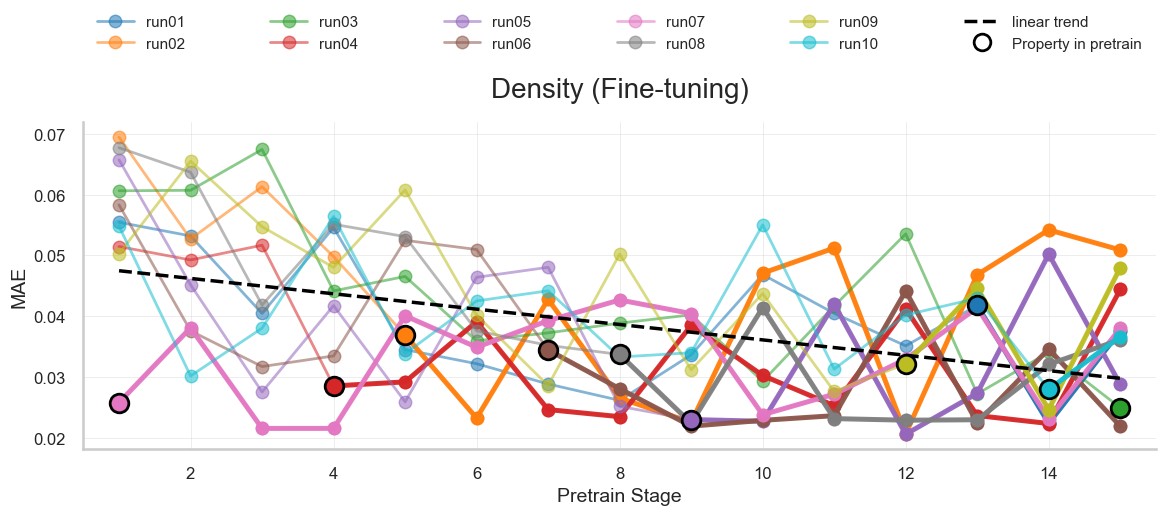

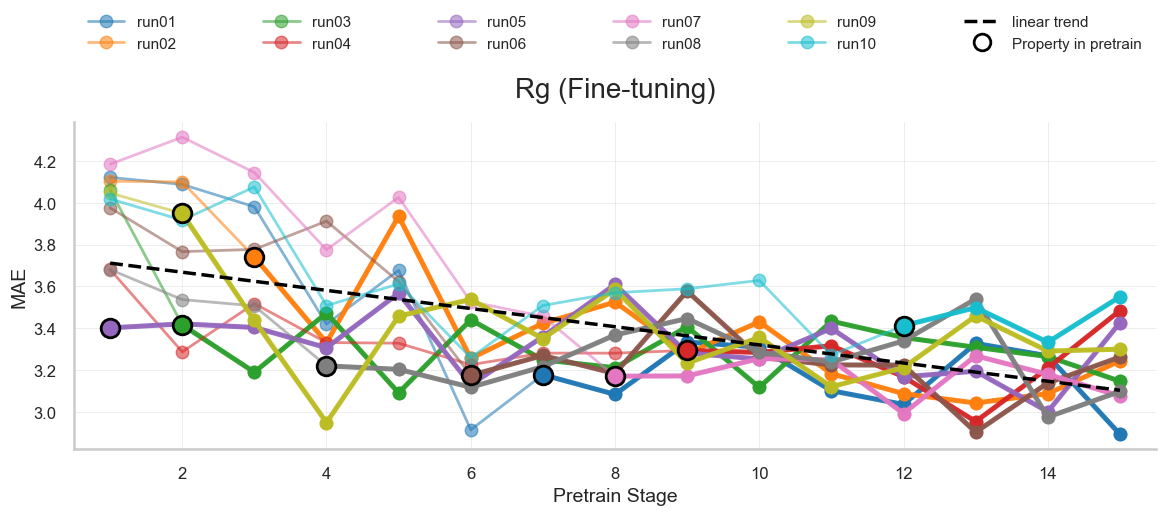

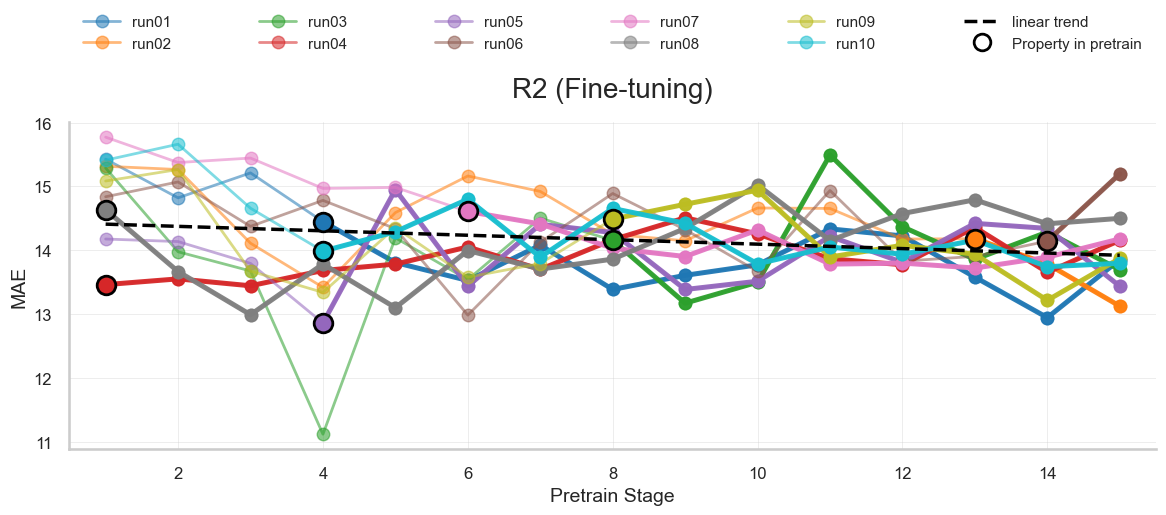

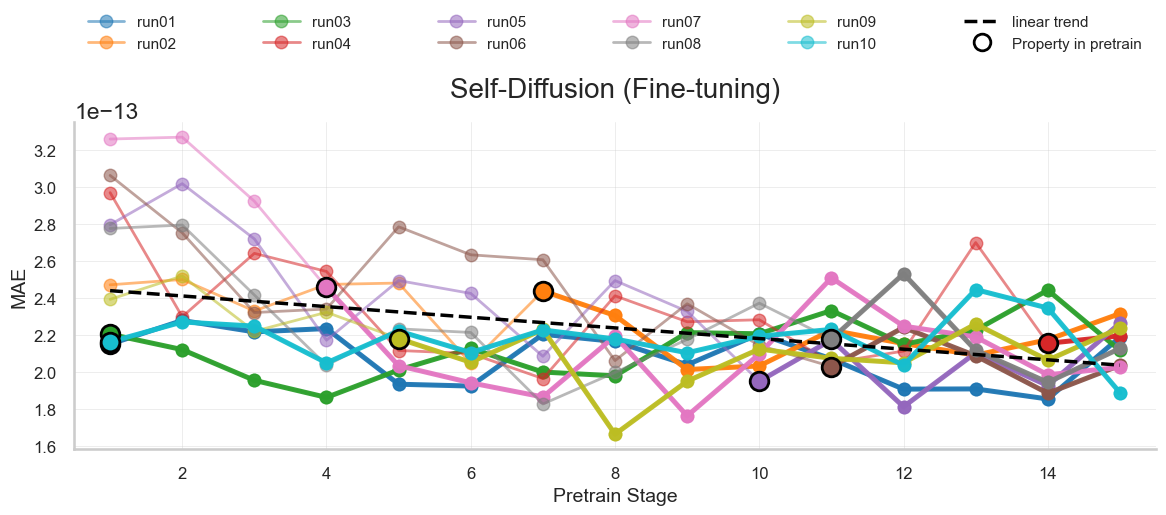

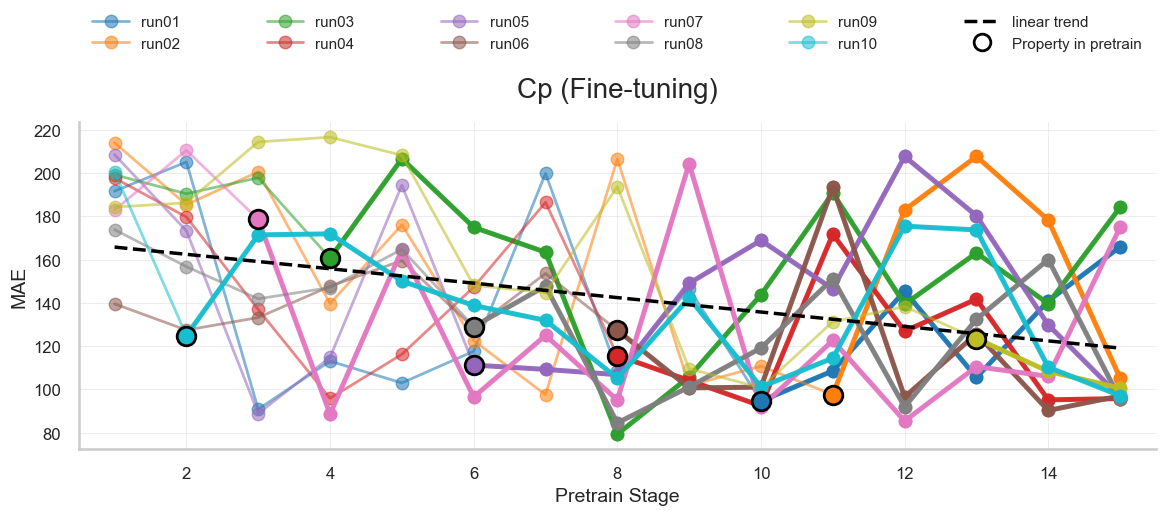

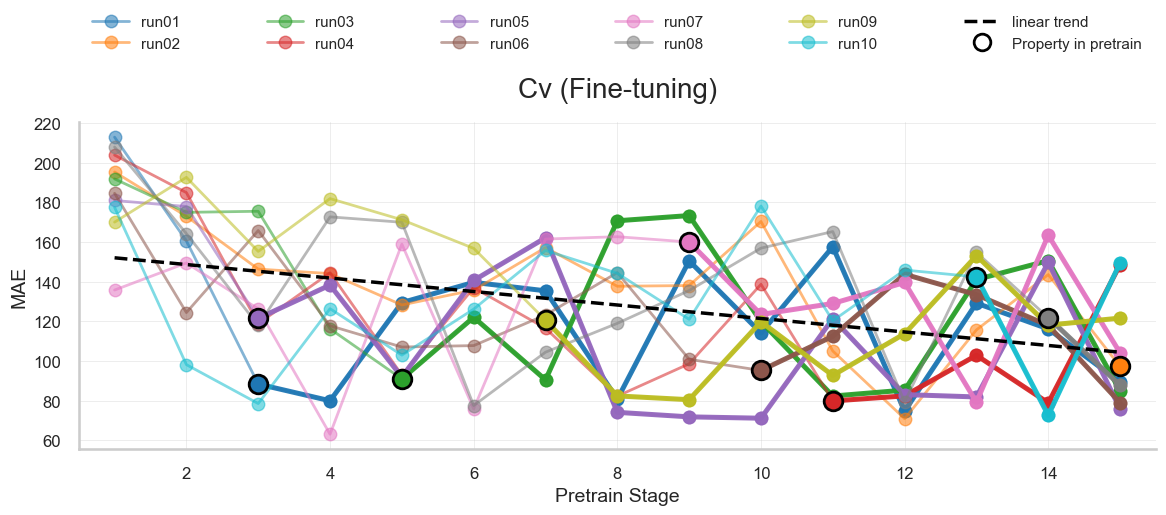

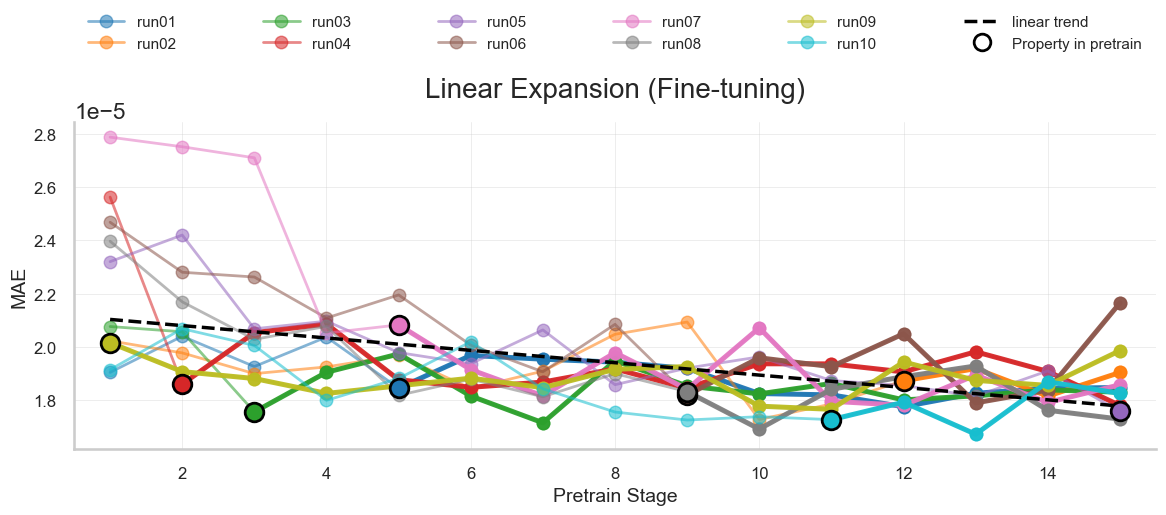

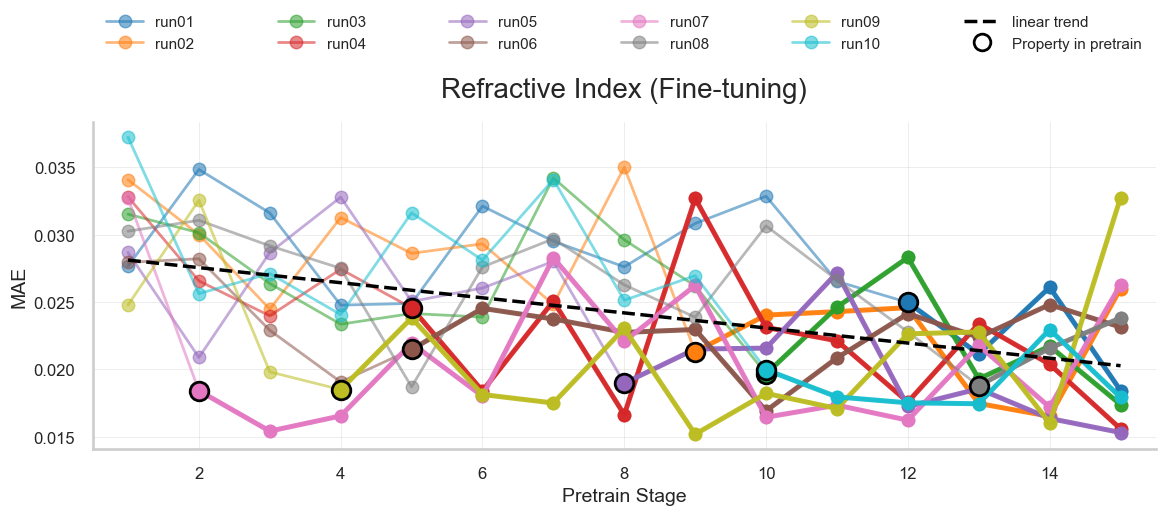

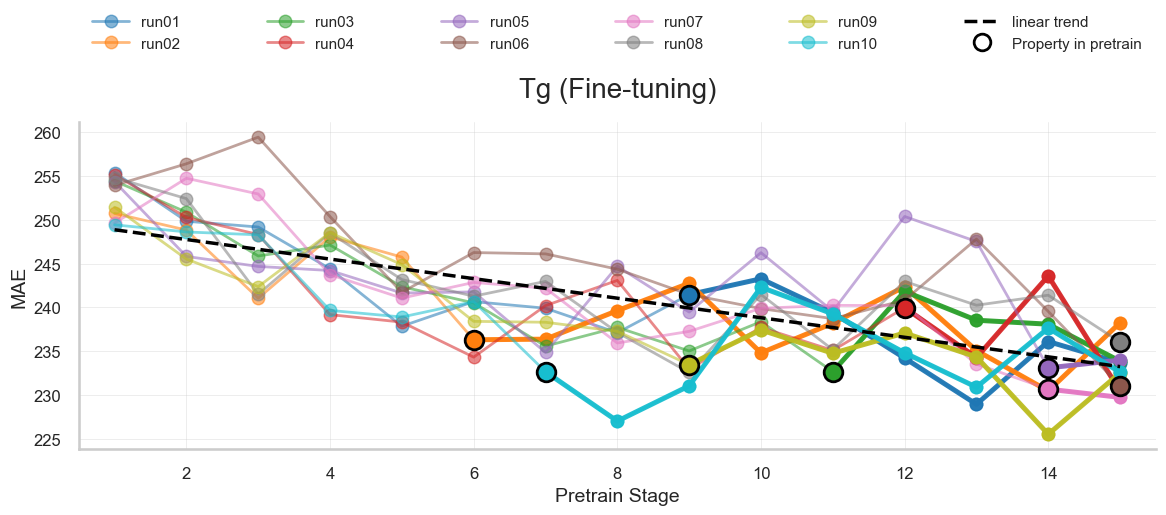

In [54]:
max_stage = finetune_df["stage"].max()

for idx, property_name in enumerate(properties):
    subset = finetune_df[finetune_df["property"] == property_name]
    if subset.empty:
        continue

    fig, ax = plt.subplots(figsize=(12, 6))
    trend_points: list[pd.DataFrame] = []

    for run_label, run_slice in subset.groupby("run"):
        run_slice = run_slice.sort_values("stage")
        ax.plot(
            run_slice["stage"],
            run_slice["mae"],
            marker="o",
            linewidth=2.0,
            color=palette[run_label],
            alpha=0.55,
            label=run_label,
        )
        post_slice = run_slice[run_slice["property_in_pretrain"]]
        if not post_slice.empty:
            ax.plot(
                post_slice["stage"],
                post_slice["mae"],
                marker="o",
                linewidth=3.6,
                color=palette[run_label],
                alpha=0.95,
            )
            inclusion_stage = post_slice["stage"].iloc[0]
            inclusion_mae = post_slice["mae"].iloc[0]
            ax.scatter(
                [inclusion_stage],
                [inclusion_mae],
                color=palette[run_label],
                edgecolor="black",
                linewidths=2.0,
                s=180,
                zorder=6,
            )
        trend_points.append(run_slice[["stage", "mae"]])

    if trend_points:
        trend_df = pd.concat(trend_points, ignore_index=True)
        trend_df = trend_df.groupby("stage", as_index=False)["mae"].mean()
        if len(trend_df) >= 2:
            z = np.polyfit(trend_df["stage"], trend_df["mae"], deg=1)
            trend_poly = np.poly1d(z)
            stage_grid = np.linspace(trend_df["stage"].min(), trend_df["stage"].max(), 200)
            ax.plot(
                stage_grid,
                trend_poly(stage_grid),
                color="black",
                linewidth=2.5,
                linestyle="--",
                label="linear trend",
            )

    pretty_name = property_name.replace("_", " ").title()
    ax.set_title(f"{pretty_name} (Fine-tuning)", fontsize=20, pad=18)

    handles, labels = ax.get_legend_handles_labels()
    seen: set[str] = set()
    unique_handles = []
    unique_labels = []
    for handle, label in zip(handles, labels):
        if not label or label in seen:
            continue
        unique_handles.append(handle)
        unique_labels.append(label)
        seen.add(label)

    pretrain_handle = Line2D(
        [], [],
        marker="o",
        linestyle="None",
        markerfacecolor="white",
        markeredgecolor="black",
        markeredgewidth=2.0,
        markersize=12,
        label="Property in pretrain",
    )
    unique_handles.append(pretrain_handle)
    unique_labels.append("Property in pretrain")

    legend = ax.legend(
        unique_handles,
        unique_labels,
        loc="upper center",
        bbox_to_anchor=(0.0, 1.07, 1.0, 0.3),
        frameon=False,
        fontsize=11,
        ncol=6,
        columnspacing=1.2,
        handlelength=2.4,
        mode="expand",
    )
    legend._legend_box.align = "left"

    ax.set_xlim(0.5, max_stage + 0.5)
    ax.set_xlabel("Pretrain Stage", fontsize=14)
    ax.set_ylabel("MAE", fontsize=14)
    ax.tick_params(axis="both", labelsize=12)
    ax.grid(True, which="major", linewidth=0.6, alpha=0.4)
    sns.despine(ax=ax)

    for line in ax.lines:
        line.set_solid_capstyle("round")

    plt.tight_layout()



Each panel isolates a single property. Semi-transparent lines trace MAE progression per run, bold segments emphasise epochs after the property joins the pretrain curriculum, and a dashed linear trendline summarises the overall trajectory.